<a href="https://colab.research.google.com/github/Edinei52/Ciencia_dados/blob/main/TCC_Facsenac_pyspark_tse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color='black'>**TCC** - **FACSENAC**</font>

### <font color='blue'>Detecção de Outliers nas Prestações de Contas Eleitorais de 2024: Uma Análise dos Dados do Tribunal Superior Eleitoral</font>

###### Aluno: Edinei Coelho Ferreira




In [ ]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.11.11


In [ ]:
!pip install findspark

Essas linhas de código abaixo são usadas para configurar o ambiente do Python para trabalhar com o Apache Spark, uma ferramenta poderosa para processamento de grandes volumes de dados.

1.   **import findspark**: A biblioteca findspark é importada para ajudar a localizar e configurar automaticamente o Spark no ambiente Python. Isso é útil especialmente quando o Spark não está no caminho padrão ou em instalações específicas.

2.  **findspark.init**: Esta função inicializa o ambiente do Spark, configurando variáveis necessárias para que as bibliotecas do Spark (como PySpark) sejam acessíveis no Python.



In [ ]:
# Importa o findspark e inicializa
import findspark
findspark.init()

In [ ]:
# Importar as bibliotecas necessarias para analise.
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import udf

#####Essas linhas de código abaixo têm como objetivo configurar a exibição de dados no pandas e ajustar o comportamento do matplotlib ao tratar logs de erro.

**pd.set_option('display.max_columns', 200):**

Essa linha configura o pandas para exibir até 200 colunas ao visualizar DataFrames. Por padrão, o pandas pode limitar a quantidade de colunas exibidas na tela para evitar sobrecarga visual, mas aqui a restrição é ampliada.

**pd.set_option('display.max_colwidth', 400):**

Isso ajusta o limite de largura (em caracteres) das colunas ao exibir valores no pandas. Por exemplo, strings longas serão mostradas inteiramente até 400 caracteres antes de serem cortadas.

**from matplotlib.axes._axes import _log as matplotlib_axes_logger:**

Importa a funcionalidade de log interno usada pelo módulo de "eixos" (axes) do matplotlib. _log é uma instância usada para rastrear mensagens de erro e warnings no matplotlib.

**matplotlib_axes_logger.setLevel('ERROR'):**

Define o nível de logging do matplotlib para apenas exibir mensagens do tipo "ERROR". Isso significa que avisos (warnings) serão ocultados, tornando a saída mais limpa ao trabalhar com gráficos.

In [ ]:
# Formatação das saídas
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

Este é o comando abaixo para instalar a biblioteca **watermark** usando o gerenciador de pacotes do Python, o **pip**. A biblioteca **watermar**k é uma extensão para o Jupyter Notebook que permite exibir informações úteis sobre o ambiente Python, como a versão do Python, bibliotecas instaladas, data, hora, entre outros.

In [ ]:
!pip install watermark

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.8 MB/s eta 0:00:00


**%reload_ext watermark:**

Esse comando é usado em Notebooks para recarregar uma extensão mágica, no caso, a extensão **watermark**. Extensões mágicas são comandos adicionais que aumentam as funcionalidades do notebook.

Aqui, ele certifica que a extensão do watermark está carregada e atualizada, caso tenha sido modificada.

**%watermark -a "Edinei Coelho Ferreira" --iversions:**

O comando %watermark é usado para gerar uma "marca d'água" informativa. Ele é configurado aqui com os seguintes parâmetros:

-a "Edinei Coelho Ferreira": A opção -a adiciona um "autor" à marca d'água, neste caso, o nome fornecido ("Edinei Coelho Ferreira").

--iversions: Essa opção exibe as versões das bibliotecas Python importadas no notebook.

In [ ]:
# Versões dos pacotes usados.
%reload_ext watermark
%watermark -a "Edinei Coelho Ferreira" --iversions

Author: Edinei Coelho Ferreira

platform  : 1.0.8
numpy     : 2.0.2
seaborn   : 0.13.2
decimal   : 1.70
pandas    : 2.2.2
findspark : 2.0.1
py4j      : 0.10.9.7
pyspark   : 3.5.5
sys       : 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
matplotlib: 3.10.0



## Preparando o ambiente Spark

In [ ]:
# Definindo semente aleatória (seed) para reprodutibilidade do notebook
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

**O que é SparkContext**?

É como o "cérebro" do Spark, responsável por coordenar as operações entre o driver (onde o programa roda) e os executores (que fazem o trabalho no cluster).

Ele cria uma conexão com o cluster Spark e configura serviços como memória compartilhada, distribuída, ou mapeia operações nos nós do cluster.

In [ ]:
# Criando o Spark Context
sc = SparkContext(appName = "Spark-TSE")

O código abaixo **spark_session = SparkSession.Builder().getOrCreate()** é usado para criar ou obter uma instância do **SparkSession**, que é o ponto de entrada para todas as funcionalidades do Spark com **DataFrame**s e **SQL**.

In [ ]:
# Criando a sessão Spark
spark_session = SparkSession.Builder().getOrCreate()

In [ ]:
# Visualiza o objeto spark_session
spark_session

## Carregando e examinando os dados

In [ ]:
# Carrega os dados do TSE a partir da sessão Spark
tse_spark = spark_session.read.options(delimiter = ";", header = 'true', inferSchema = 'true', encoding = 'latin1').csv('/content/extrato_bancario_candidato_2024.csv')


O **pyspark.sql.dataframe.DataFrame** é uma classe fundamental no PySpark, a biblioteca de processamento de dados da Apache Spark para Python. Ela representa uma coleção distribuída de dados organizados em colunas, de forma similar a uma tabela em um banco de dados relacional ou a um DataFrame no pandas (outra biblioteca Python muito popular para análise de dados).

In [ ]:
# Tipo do objeto
type(tse_spark)

pyspark.sql.dataframe.DataFrame

In [ ]:
# Visualiza os dados
tse_spark.show(5)

+----------+-------------------+-------------+-----------------------+------------------------+--------------------+----------+---------+---------+--------------------+-------------+--------------------+-------------+-----------+--------------------+--------+--------------------+----------+----------+--------+-------------+--------------------+--------------------+----------------------+--------------------+-----------------------+--------------------+----------------+--------------------+------------------------+
|DT_GERACAO|         HH_GERACAO|AA_REFERENCIA|NR_CNPJ_PRESTADOR_CONTA|DS_CARGO_PRESTADOR_CONTA|  NM_PRESTADOR_CONTA|SG_PARTIDO|NM_ESFERA|TP_PESSOA|       DS_LANCAMENTO|DT_LANCAMENTO|        NR_DOCUMENTO|TP_LANCAMENTO|TP_OPERACAO|         NM_OPERACAO|CD_BANCO|            NM_BANCO|NR_AGENCIA|  NR_CONTA|TP_CONTA|VR_LANCAMENTO|CD_BANCO_CONTRAPARTE|NM_BANCO_CONTRAPARTE|NR_AGENCIA_CONTRAPARTE|NR_CONTA_CONTRAPARTE|NR_CPF_CNPJ_CONTRAPARTE|      NM_CONTRAPARTE|CD_FONTE_RECURSO|    NM_

**tse_spark.printSchema()**: Este comando exibe a estrutura (esquema) do DataFrame

**tse_spark.** Ele mostra os nomes das colunas, os tipos de dados de cada coluna **(como StringType, IntegerType**, etc.), e se há permissões para valores nulos em cada coluna. É excelente para entender a "forma" dos dados com os quais você está trabalhando.

**tse_spark.select([...]).show():**

Aqui, você está usando uma expressão Python que combina várias funções do PySpark:

**when(col(c).isNull(), c)**: Verifica se os valores em uma coluna c são nulos **(NULL)**.

**count(when(...))**: Conta o número de valores nulos em cada coluna.

**.alias(c)**: Dá um nome para a coluna no resultado, usando o nome original da coluna.

**for c in tse_spark.columns**: Itera sobre todas as colunas do DataFrame **tse_spark.**

Esse comando resulta em uma análise de valores nulos em todas as colunas do DataFrame. Ele cria um DataFrame com os nomes das colunas originais e suas respectivas contagens de valores nulos. O método **.show() **então exibe esses resultados de forma tabular no console.

## Verificando e limpando os dados

In [ ]:
# Visualiza os metadados (schema) e valores ausentes
tse_spark.printSchema()
tse_spark.select([count(when(col(c).isNull(), c)).alias(c) for c in tse_spark.columns]).show()

root
 |-- DT_GERACAO: string (nullable = true)
 |-- HH_GERACAO: timestamp (nullable = true)
 |-- AA_REFERENCIA: integer (nullable = true)
 |-- NR_CNPJ_PRESTADOR_CONTA: long (nullable = true)
 |-- DS_CARGO_PRESTADOR_CONTA: string (nullable = true)
 |-- NM_PRESTADOR_CONTA: string (nullable = true)
 |-- SG_PARTIDO: string (nullable = true)
 |-- NM_ESFERA: string (nullable = true)
 |-- TP_PESSOA: integer (nullable = true)
 |-- DS_LANCAMENTO: string (nullable = true)
 |-- DT_LANCAMENTO: string (nullable = true)
 |-- NR_DOCUMENTO: string (nullable = true)
 |-- TP_LANCAMENTO: string (nullable = true)
 |-- TP_OPERACAO: integer (nullable = true)
 |-- NM_OPERACAO: string (nullable = true)
 |-- CD_BANCO: integer (nullable = true)
 |-- NM_BANCO: string (nullable = true)
 |-- NR_AGENCIA: integer (nullable = true)
 |-- NR_CONTA: long (nullable = true)
 |-- TP_CONTA: integer (nullable = true)
 |-- VR_LANCAMENTO: string (nullable = true)
 |-- CD_BANCO_CONTRAPARTE: integer (nullable = true)
 |-- NM_BAN

In [ ]:
# Tratar valores nulos e ausentes
# Substituir '#NULO' e '#NE' por 'None', assim com os valores -1 e -3 para os campos numéricos
# É importante verificar o arquivo "leiame.pdf" fornecido pelo TSE
from pyspark.sql.functions import when

tse_spark = tse_spark.replace(['#NULO', '#NE'], None)
tse_spark = tse_spark.replace([-1, -3], None)

In [ ]:
# Verifica o número de linhas
tse_spark.count()

4823139

## Estatística Descritiva

In [ ]:
from pyspark.sql.functions import col, regexp_replace

# Substituir vírgulas por pontos
tse_spark = tse_spark.withColumn("valor", regexp_replace(col("VR_LANCAMENTO"), ",", "."))

# Converter a coluna para numérica
tse_spark = tse_spark.withColumn("valor_numerico", col("valor").cast("double"))

# Excluir valores missing
tse_spark = tse_spark.na.drop(subset = ["valor_numerico"])

In [ ]:
# Nome da variável de interesse
valor = 'valor_numerico'

# Obter o resumo estatístico da variável de interesse
resumo_estatistico = tse_spark.select(valor).describe()

# Mostrar o resumo estatístico
resumo_estatistico.show()

+-------+------------------+
|summary|    valor_numerico|
+-------+------------------+
|  count|           4823139|
|   mean|2781.1664959726436|
| stddev|   35205.153526378|
|    min|               0.0|
|    max|           1.945E7|
+-------+------------------+



## Analisando distribuições

In [ ]:
# Distribuição de lançamentos por tipo de operação
tse_spark.groupBy('TP_OPERACAO').count().orderBy(col('count').desc()).show()

+-----------+-------+
|TP_OPERACAO|  count|
+-----------+-------+
|        117|2490702|
|        120| 735909|
|        209| 657404|
|        101| 199707|
|        104| 182886|
|        105| 155127|
|        205| 137278|
|        213| 118140|
|        201|  77013|
|        112|  13537|
|        114|  11111|
|        999|   8515|
|        203|   7492|
|        215|   6727|
|        204|   5923|
|        220|   2932|
|        124|   2542|
|        214|   2016|
|        103|   1993|
|        206|   1761|
+-----------+-------+
only showing top 20 rows



In [ ]:
# Distribuição de lançamentos por tipo de pessoa (Física/Jurídica)
tse_spark.groupBy('TP_PESSOA').count().show()

+---------+-------+
|TP_PESSOA|  count|
+---------+-------+
|     NULL| 181024|
|        1|2919678|
|        2|1722437|
+---------+-------+



## Verificando a Frequência de Categorias

In [ ]:
# Partidos com mais lançamentos
tse_spark.groupBy('SG_PARTIDO').count().orderBy('count', ascending = False).show(20)

+-------------+------+
|   SG_PARTIDO| count|
+-------------+------+
|           PL|579924|
|           PT|459136|
|          MDB|441968|
|           PP|430651|
|        UNIÃO|409490|
|          PSD|408020|
| REPUBLICANOS|351001|
|         PODE|215625|
|          PSB|205533|
|         PSDB|190677|
|          PDT|180126|
|         PRTB|136024|
|          PRD|114332|
|SOLIDARIEDADE|110610|
|       AVANTE|106296|
|         NOVO| 88579|
|         PSOL| 85711|
|    CIDADANIA| 60277|
|      PC do B| 54903|
|           PV| 47553|
+-------------+------+
only showing top 20 rows



# Valores arrecadados por Partido

In [ ]:
from pyspark.sql.functions import col, sum as _sum

# Agrupar por 'SG_PARTIDO' e somar os valores de 'VR_LANCAMENTO', depois ordenar
tse_spark.groupBy('SG_PARTIDO') \
  .agg(_sum('valor_numerico').alias('total_vr_lancamento')) \
  .orderBy(col('total_vr_lancamento').desc()) \
  .show()

+-------------+--------------------+
|   SG_PARTIDO| total_vr_lancamento|
+-------------+--------------------+
|           PL|     2.09108689393E9|
|        UNIÃO|1.3634924854599836E9|
|          PSD|1.3490686413499908E9|
|           PT|1.3367785260699878E9|
|          MDB|1.3260101065799882E9|
|           PP|1.2102125561099896E9|
| REPUBLICANOS| 8.872545678799956E8|
|         PODE|      5.5714112371E8|
|          PSB| 5.237998529999998E8|
|          PDT|5.0319293380000037E8|
|         PSDB|4.8221207933000064E8|
|       AVANTE| 2.614473820400002E8|
|         PSOL|2.5674452106000024E8|
|SOLIDARIEDADE| 2.296089390100003E8|
|          PRD|2.1655038745000026E8|
|         NOVO|1.8412821677000007E8|
|    CIDADANIA|      1.5811367915E8|
|      PC do B|1.2472610631999998E8|
|           PV|1.1459865420000002E8|
|         REDE| 6.446173408999997E7|
+-------------+--------------------+
only showing top 20 rows



# 20 maiores valores arrecadados por Prestador de Contas (CNPJ/Candidato)

In [ ]:
# Agrupar por 'NR_CNPJ_PRESTADOR_CONTA' e somar os valores de 'VR_LANCAMENTO', depois ordenar
tse_spark.groupBy('NR_CNPJ_PRESTADOR_CONTA') \
  .agg(_sum('valor_numerico').alias('total_vr_lancamento')) \
  .orderBy(col('total_vr_lancamento').desc()) \
  .show(20)

+-----------------------+--------------------+
|NR_CNPJ_PRESTADOR_CONTA| total_vr_lancamento|
+-----------------------+--------------------+
|         56533387000104|1.1864181947999999E8|
|         56235333000154|          9.028074E7|
|         56233510000163| 7.360533622000001E7|
|         56507393000189|        4.26433575E7|
|         56324323000195|       4.007597724E7|
|         56355648000135|       3.911890242E7|
|         56450762000144|3.5941484300000004E7|
|         56574927000190|       3.584584946E7|
|         56349955000103|       3.229636776E7|
|         56516157000129|2.8998442899999995E7|
|         56277196000110|       2.847807385E7|
|         56403350000153|       2.692625872E7|
|         56351329000151|       2.597347538E7|
|         56188937000197|2.4740104650000006E7|
|         56450417000100|        2.47220823E7|
|         56168855000180|        2.46137624E7|
|         56448359000180|2.4188612999999996E7|
|         56742156000100|       2.407270466E7|
|         564

In [ ]:
# Cargos com mais lançamentos
tse_spark.groupBy('DS_CARGO_PRESTADOR_CONTA').count().orderBy('count', ascending = False).show()

+------------------------+-------+
|DS_CARGO_PRESTADOR_CONTA|  count|
+------------------------+-------+
|                VEREADOR|3343543|
|                PREFEITO|1305508|
|           VICE-PREFEITO| 174088|
+------------------------+-------+



## Analisando Lançamentos por Data

In [ ]:
from pyspark.sql.functions import to_date

# Convertendo datas para o formato correto
tse_spark = tse_spark.withColumn('DT_LANCAMENTO', to_date(col('DT_LANCAMENTO'), 'dd/MM/yyyy'))

In [ ]:
# Lançamentos ao longo do tempo
tse_spark.groupBy(year('DT_LANCAMENTO'), month('DT_LANCAMENTO')).sum('valor_numerico').orderBy('year(DT_LANCAMENTO)', 'month(DT_LANCAMENTO)').show()

+-------------------+--------------------+--------------------+
|year(DT_LANCAMENTO)|month(DT_LANCAMENTO)| sum(valor_numerico)|
+-------------------+--------------------+--------------------+
|               2024|                   7|              9047.0|
|               2024|                   8|2.1551329060499988E9|
|               2024|                   9| 7.869979943960063E9|
|               2024|                  10|3.1673810062000847E9|
|               2024|                  11|2.2144968900999987E8|
+-------------------+--------------------+--------------------+



## Análises específicas

In [ ]:
# Bancos mais usados
tse_spark.groupBy('NM_BANCO').count().orderBy('count', ascending = False).show(20)

+--------------------+-------+
|            NM_BANCO|  count|
+--------------------+-------+
|          BCO BRASIL|3467370|
|CAIXA ECONOMICA F...| 514683|
|  ITA? UNIBANCO S.A.| 243738|
|BANCO DO ESTADO D...| 206194|
|        BCO BRADESCO| 197396|
|            BANESTES|  70778|
|       BCO SANTANDER|  66314|
|BANCO DO ESTADO D...|  41681|
|BANCO DO NORDESTE...|  13726|
|Banco do Estado d...|   1159|
|BANCO COOPERATIVO...|     94|
|BANCO MERCANTIL D...|      6|
+--------------------+-------+



In [ ]:
# Análise de contrapartes
tse_spark.groupBy('NM_CONTRAPARTE').count().orderBy('count', ascending = False).show(20)

+--------------------+------+
|      NM_CONTRAPARTE| count|
+--------------------+------+
|              #NULO#|184895|
|BANCO DO BRASIL S.A.| 86961|
|Facebook Servicos...| 62946|
|BRADESCO/TARIFA B...| 32394|
|SECRETARIA DO TES...| 25269|
|TITULO - OUTRO BA...| 23947|
|CAIXA ECONOMICA F...| 21850|
|PARTIDO LIBERAL (PL)| 17441|
|PARTIDO DOS TRABA...| 14466|
|Facebook Servicos...| 13659|
|TITULO - OUTRO BA...| 13364|
|                 MDB| 10536|
|REPUBLICANOS - BR...|  9639|
|        UNIAO BRASIL|  9585|
|PROGRESSISTAS - B...|  7729|
|FACEBOOK SERVICOS...|  5885|
| PARTIDO LIBERAL  PL|  5429|
|             PODEMOS|  4988|
|PARTIDO SOCIAL DE...|  4817|
|DLOCAL BRASIL I D...|  3976|
+--------------------+------+
only showing top 20 rows



## Verificando a Consistência dos Dados

In [ ]:
from pyspark.sql.functions import when

# Verificar se todos os lançamentos têm contrapartes válidas
tse_spark.select([count(when(col('NR_CPF_CNPJ_CONTRAPARTE').isNull(), 'NR_CPF_CNPJ_CONTRAPARTE')).alias('NR_CPF_CNPJ_CONTRAPARTE'),
           count(when(col('NM_CONTRAPARTE').isNull(), 'NM_CONTRAPARTE')).alias('NM_CONTRAPARTE')]).show()

+-----------------------+--------------+
|NR_CPF_CNPJ_CONTRAPARTE|NM_CONTRAPARTE|
+-----------------------+--------------+
|                 193636|             0|
+-----------------------+--------------+



## Outliers

Agora, utilizaremos técnicas para identificação de possíveis outliers

In [ ]:
# Estatísticas Descritivas
# Obter estatísticas descritivas
tse_spark.describe('valor_numerico').show()

+-------+------------------+
|summary|    valor_numerico|
+-------+------------------+
|  count|           4823139|
|   mean|2781.1664959726436|
| stddev|   35205.153526378|
|    min|               0.0|
|    max|           1.945E7|
+-------+------------------+



A fórmula do **Z-Score** é usada para calcular o número de desvios padrão que um valor está distante da média de um conjunto de dados. A fórmula é:

$$ Z = \frac{\text{valor_numerico} - \text{média}}{\text{desvio padrão}} $$

**Interpretação:**

Um **Z-Score positivo** indica que o valor está acima da média.

Um **Z-Score negativo** indica que o valor está abaixo da média.

O Z-Score ajuda a determinar quão incomum ou significativo um valor é dentro de um conjunto, sendo muito usado em estatística para padronização.

**mean:** Esta função calcula a média aritmética (ou seja, o valor médio) de uma coluna específica em um DataFrame Spark.

**stddev:** Esta função calcula o desvio padrão da coluna especificada, que é uma medida de dispersão ou variação dos dados em torno da média.

**tse_spark.select("z_score"):** Seleciona a coluna chamada **z_score** de um DataFrame Spark chamado **tse_spark**. O resultado ainda é um DataFrame, mas com apenas essa coluna.

**.rdd:** Converte o DataFrame para um RDD (Resilient Distributed Dataset), que é uma estrutura de dados mais primitiva no Spark, usada para paralelismo e processamento distribuído.

**.flatMap(lambda x: x):** Aplica uma transformação chamada **flatMap** no **RDD.** Aqui, a função lambda **lambda x: x** é usada para "desembrulhar" os valores dentro das linhas do RDD. Basicamente, isso pega os valores da coluna **z_score** de cada linha e os transforma em um formato simples (uma lista achatada).

**.collect():** Reúne todos os dados processados no RDD em uma única lista Python no driver local. Essa operação pode ser cara em termos de memória se o conjunto de dados for muito grande, pois transfere todos os dados para a memória local.

In [ ]:
# Z-Score

from pyspark.sql.functions import mean, stddev

# Calcular a média e o desvio padrão da variável
mean_value = tse_spark.select(mean(col("valor_numerico"))).collect()[0][0]
stddev_value = tse_spark.select(stddev(col("valor_numerico"))).collect()[0][0]

# Calcular o Z-Score
tse_spark = tse_spark.withColumn("z_score", (col("valor_numerico") - mean_value) / stddev_value)

# Coletar os dados para visualização
z_scores = tse_spark.select("z_score").rdd.flatMap(lambda x: x).collect()

Em português, **threshold** geralmente se refere a um limite ou valor de corte que é usado como referência em diversas situações na programação ou análise de dados. Aqui estão alguns exemplos de como isso pode ser aplicado:

**Machine Learning** **(Aprendizado de Máquina):** O threshold é usado para determinar, por exemplo, a probabilidade mínima para classificar uma previsão em uma categoria específica. Por exemplo, em um modelo de classificação binária, você pode definir um threshold de 0,5 para decidir se algo pertence à classe A ou B.

**Filtragem de Dados:** Um threshold pode ser utilizado para incluir ou excluir dados. Por exemplo, você pode filtrar uma tabela para manter apenas valores acima ou abaixo de um determinado valor.

**PySpark:** No PySpark, você pode comparar valores em uma coluna com um threshold para aplicar filtros ou executar cálculos. Por exemplo, filtrar linhas em que uma coluna tenha valores maiores ou menores que o limite definido.

In [ ]:
# Definir um limiar para identificar pontos anômalos
threshold = 3 # Ajuste conforme necessário

A coluna "label" será:

1 se o valor absoluto de **"z_score"** for maior que threshold.

-1 se o valor absoluto de **"z_score"** não for maior que threshold.

E o **threshold** for definido como 3, significa que o valor limite para tomada de decisão, categorização ou filtragem é 3. No caso do código que você forneceu:

Por exemplo:

Para um z_score de 4.5, o valor seria 1 (pois 4.5 > 3).

Para um z_score de -2.8, o valor seria -1 (pois |-2.8| ≤ 3).

In [ ]:
from pyspark.sql.functions import abs

# Criar a coluna 'label' baseada no Z-Score
tse_spark = tse_spark.withColumn("label", when(abs(col("z_score")) > threshold, 1).otherwise(-1))

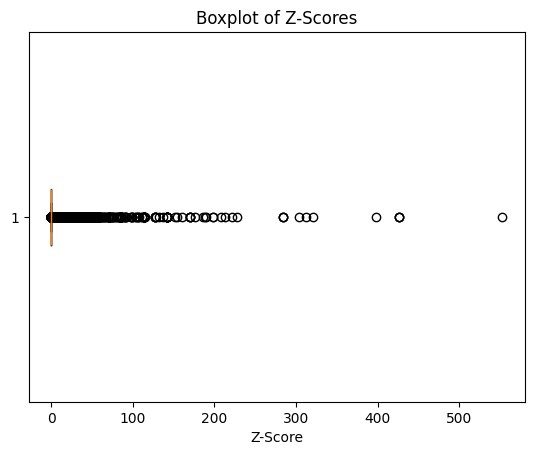

In [ ]:
# Visualizar os resultados
plt.boxplot(z_scores, vert = False)
plt.title('Boxplot of Z-Scores')
plt.xlabel('Z-Score')
plt.show()

Esse conjunto abaixo de fórmulas está relacionado ao cálculo do **IQR (Interquartile Range)**, ou Intervalo Interquartil, uma medida estatística que representa a dispersão dos dados, excluindo outliers. Aqui está a explicação:

**Q1** **(Primeiro Quartil):**

**z_scores_tse['z_score'].quantile(0.25)** calcula o valor do primeiro quartil, ou seja, o ponto que divide os 25% inferiores dos dados do restante. É o valor abaixo do qual 25% dos valores estão localizados.

**Q3** **(Terceiro Quartil):**

**z_scores_tse['z_score'].quantile(0.75)** calcula o valor do terceiro quartil, que é o ponto que separa os 25% superiores dos dados. Ou seja, 75% dos dados estão abaixo desse valor.

**IQR** **(Intervalo Interquartil):**

**IQR** **= Q3 - Q1:** Subtraindo o valor do Q1 (primeiro quartil) do Q3 (terceiro quartil), você obtém o intervalo interquartil, que mostra a amplitude central dos 50% dos dados.

O **IQR **é frequentemente usado para identificar outliers em um conjunto de dados. Valores são considerados outliers se estiverem abaixo de:

**Q1** - **1.5** * **IQR** (extremamente baixos) ou acima de:

**Q3** + **1.5** * **IQR** (extremamente altos).

In [ ]:
# Convertendo a lista de z_scores para um DataFrame do Pandas para facilitar o cálculo
z_scores_tse = pd.DataFrame(z_scores, columns = ['z_score'])

# Calculando Q1 (25º percentil) e Q3 (75º percentil)
Q1 = z_scores_tse['z_score'].quantile(0.25)
Q3 = z_scores_tse['z_score'].quantile(0.75)
IQR = Q3 - Q1

# Definindo limites para outliers
lower_bound = Q1 - 3.0 * IQR
upper_bound = Q3 + 3.0 * IQR

# Identificando outliers
outliers = z_scores_tse[(z_scores_tse['z_score'] < lower_bound) | (z_scores_tse['z_score'] > upper_bound)]
print("Outliers:\n", outliers)

Outliers:
           z_score
7        0.202051
11       0.063026
26       0.159603
60       0.157984
63       0.067639
...           ...
4823068  0.631124
4823085  0.076376
4823092  0.291012
4823113  0.858117
4823117  0.500746

[418762 rows x 1 columns]


Ranking

In [ ]:
# Ranqueando os outliers em ordem decrescente de valor absoluto do Z-Score
ranked_outliers = outliers.reindex(outliers['z_score'].abs().sort_values(ascending = False).index)

print("Outliers Ranqueados:\n", ranked_outliers)

Outliers Ranqueados:
             z_score
680917   552.396933
3682368  425.994985
3583038  425.994985
2208932  425.994985
3243480  397.590052
...             ...
3211988    0.060143
1749324    0.060143
3378223    0.060136
3741796    0.060129
3307788    0.060129

[418762 rows x 1 columns]


Visualizando os 10 maiores doações de campanha

In [ ]:
# Selecionando os 10 maiores outliers
top_10_outliers = ranked_outliers.head(10)
print("Top 10 Outliers:\n", top_10_outliers)

Top 10 Outliers:
             z_score
680917   552.396933
3682368  425.994985
3583038  425.994985
2208932  425.994985
3243480  397.590052
4792903  320.896735
1148261  312.375256
1940581  303.853776
3977132  283.970323
1209467  283.970323


## Teste de Kolmogorov-Smirnov (KS)

Agora, vamos testar se a nossa variável segue uma distribuição normal usando o PySpark. Usaremos o Teste de Kolmogorov-Smirnov (KS), pois ele é mais adequado para grandes conjuntos de dados ou em situações onde se precisa comparar uma amostra com uma distribuição específica (não necessariamente normal).

$$ D = \max | F_1(x) - F_2(x) | $$

Onde:

𝐷
𝑛
: Estatística KS (máxima diferença cumulativa).

𝐹
𝑛
(
𝑥
)
: Função de distribuição acumulada empírica da amostra.

𝐹
(
𝑥
)
: Função de distribuição acumulada teórica (esperada).

max
⁡
: Valor máximo das diferenças absolutas.

In [ ]:
from pyspark.ml.stat import KolmogorovSmirnovTest

# Realizar o teste KS para verificar normalidade
ks_result = KolmogorovSmirnovTest.test(tse_spark, 'z_score', 'norm').head()

# Resultados do teste
print("Statistic:", ks_result[0])
print("p-value:", ks_result[1])

if ks_result[1] < 0.05:
    print("Rejeitamos a hipótese nula de que os dados seguem uma distribuição normal.")
else:
    print("Não rejeitamos a hipótese nula de que os dados seguem uma distribuição normal.")

Statistic: 5.3878016492703296e-09
p-value: 0.4685167705436564
Não rejeitamos a hipótese nula de que os dados seguem uma distribuição normal.


Interpretação dos Resultados:

- **Statistic:** Representa a estatística do teste KS, que é a maior diferença entre a função de distribuição empírica da amostra e a função de distribuição cumulativa da distribuição teórica especificada.
- **p-value:** Indica a probabilidade de observar um valor da estatística de teste tão extremo quanto, ou mais extremo que, o valor observado sob a hipótese nula.
- Se o valor p for menor que o nível de significância (comumente 0.05), rejeitamos a hipótese nula, indicando que os dados não seguem uma distribuição normal.
- Se o valor p for maior que o nível de significância, não rejeitamos a hipótese nula, indicando que não há evidência suficiente para afirmar que os dados não seguem uma distribuição normal.

Por fim, realizaremos o Teste de Grubb que é utilizado para detectar outliers em um conjunto de dados. No entanto, o PySpark não possui uma implementação direta desse teste. Portanto, lançaremos mão da biblioteca externa SciPy para realizar o teste.

## Teste de Grubbs

Por fim, na análise estatística, realizaremos o Teste de Gubbs, que é um método estatístico utilizado para detectar um único outlier em um conjunto de dados que se assume seguir uma distribuição normal. O teste é particularmente útil quando se deseja identificar valores aberrantes.

In [ ]:
# Selecionar a coluna de interesse
tse_selected = tse_spark.select('valor_numerico')

# Converter para Pandas DataFrame
tse_pandas = tse_selected.toPandas()

In [ ]:
from scipy.stats import t

# Função para calcular o Teste de Grubbs
def grubbs_test(x):
    n = len(x)
    mean_x = np.mean(x)
    std_x = np.std(x, ddof = 1)
    abs_diff = np.abs(x - mean_x)
    max_diff = np.max(abs_diff)
    G = max_diff / std_x

    t_dist = t.ppf(1 - 0.05 / (2 * n), n - 2)
    G_critical = ((n - 1) / np.sqrt(n)) * np.sqrt(t_dist ** 2 / (n - 2 + t_dist ** 2))

    return G, G_critical

# Aplicar o Teste de Grubbs
values = tse_pandas['valor_numerico'].values
G, G_critical = grubbs_test(values)

print(f"Estatística G calculada: {G}")
print(f"Valor crítico de G: {G_critical}")

if G > G_critical:
    print("Há pelo menos um outlier no conjunto de dados.")
else:
    print("Não há outliers significativos no conjunto de dados.")

Estatística G calculada: 552.3969329925754
Valor crítico de G: 5.72460825320496
Há pelo menos um outlier no conjunto de dados.


Interpretação dos Resultados:

- Estatística G: Representa a maior diferença padronizada entre um ponto de dados e a média do conjunto de dados.
- Valor Crítico G: Calculado com base na distribuição t de Student, leva em conta o tamanho da amostra e o nível de significância (alpha).
- Se a estatística G for maior que o valor crítico G, isso indica que há pelo menos um outlier significativo no conjunto de dados.
- Se a estatística G for menor ou igual ao valor crítico G, não há evidência suficiente para afirmar que há outliers significativos no conjunto de dados.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


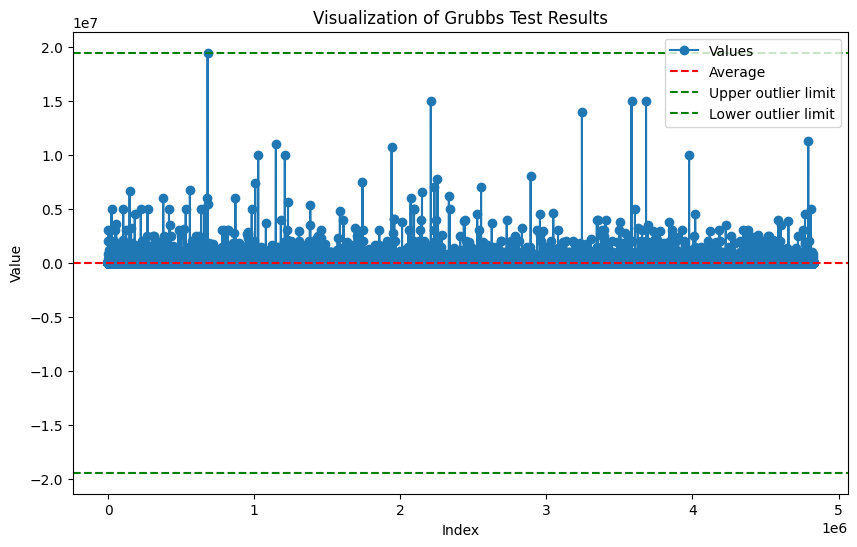

In [ ]:
# Visualização dos resultados
plt.figure(figsize = (10, 6))
plt.plot(values, marker = 'o', linestyle = '-', label = 'Values')
plt.axhline(y = np.mean(values), color = 'r', linestyle = '--', label = 'Average')
plt.axhline(y = np.mean(values) + G * np.std(values, ddof = 1), color = 'g', linestyle = '--', label = 'Upper outlier limit')
plt.axhline(y = np.mean(values) - G * np.std(values, ddof = 1), color = 'g', linestyle = '--', label = 'Lower outlier limit')
plt.legend()
plt.title('Visualization of Grubbs Test Results')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

> # Machine Learning

Até aqui, o modelo apresentou uma análise inicial da base de dados do TSE utilizando PySpark para processamento e algumas técnicas estatísticas para a identificação de outliers, como o Teste de Grubbs. Para melhorar e inovar o estudo, podemos aplicar métodos de machine learning mais avançados e adequados à detecção de outliers. Vamos avaliar a seguir algumas abordagens que podem ser objetivas e replicáveis para a tarefa em questão:

In [ ]:
# Imports
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, pandas_udf
from sklearn.ensemble import IsolationForest

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# Adicionar uma coluna de identificador único
tse_spark = tse_spark.withColumn('id', monotonically_increasing_id())

## 1. Isolation Forest

Baseado em árvores de decisão abaixo, o Isolation Forest isola observações ao particionar os dados de forma recursiva. Observações que requerem poucas partições para serem isoladas são consideradas outliers. Ou seja, a vantagem é que o modelo identifica outliers isolando observações que são menos frequentes em menor número de divisões.

O decorador **@pandas_udf("int")** é usado no PySpark, que é uma biblioteca para processamento de dados em larga escala. Especificamente, é usado para definir uma função de usuário (User-Defined Function ou UDF) que opera em dados em formato de Pandas.

Essa função **isolation_forest_udf** usa o algoritmo Isolation Forest para detectar anomalias (ou outliers) em uma série de dados fornecida. Ela recebe como entrada uma série do Pandas **(pd.Series)** e retorna outra série que contém os resultados da análise (1 para "normal" e -1 para "anomalia").

Essa função **isolation_forest_udf** usa o algoritmo Isolation Forest para detectar anomalias (ou outliers) em uma série de dados fornecida. Ela recebe como entrada uma série do Pandas **(pd.Series)** e retorna outra série que contém os resultados da análise (1 para "normal" e -1 para "anomalia").

**IsolationForest**: É um algoritmo baseado em árvores que identifica anomalias isolando pontos em subgrupos dos dados.

**contamination=0.01:** Define que aproximadamente 1% dos dados são considerados como anomalias.

**random_state=42:** Garante que o resultado seja reproduzível (usando uma semente fixa para geração aleatória).

**series.values:** Extrai os valores da série como um array NumPy.

**.reshape(-1, 1):** Ajusta os dados para que fiquem no formato de uma matriz 2D (necessário para o modelo, pois ele espera uma matriz com uma coluna).

**model.fit_predict(series):** O modelo é treinado e usado para prever ao mesmo tempo. Ele retorna:

**1:** Indica um valor normal.

**-1:** Indica que o valor é uma anomalia (outlier).

**pd.Series():** Converte os resultados do NumPy de volta para uma série do Pandas.

In [ ]:
# Função Pandas UDF para aplicar o Isolation Forest
@pandas_udf("int")
def isolation_forest_udf(series: pd.Series) -> pd.Series:
    model = IsolationForest(contamination = 0.01, random_state = 42)
    series = series.values.reshape(-1, 1)
    return pd.Series(model.fit_predict(series))

# Aplicar o UDF ao DataFrame do Spark
tse_spark = tse_spark.withColumn('outlier_if', isolation_forest_udf(col('valor_numerico')))

## 2. Local Outlier Factor (LOF)

A função utiliza o modelo **Local Outlier Factor (LOF)** para identificar anomalias (outliers) em uma série de dados. Ela retorna uma nova série Pandas com os resultados da análise, onde os valores indicam se o ponto é normal ou um outlier:

1: Dado normal.

-1: Dado considerado como outlier.

**LocalOutlierFactor:** É um algoritmo que mede a densidade de vizinhança para identificar pontos que estão fora do padrão (outliers).

**n_neighbors=20:** Define que a densidade de cada ponto será comparada com seus 20 vizinhos mais próximos.

**contamination=0.01:** Indica que cerca de 1% dos dados são considerados anomalias.

**series.values:** Converte os dados da série para um array NumPy.

**.reshape(-1, 1):** Ajusta os dados para o formato esperado pelo modelo, uma matriz 2D com uma única coluna.

**model.fit_predict(series):** O modelo calcula e retorna os resultados, indicando:

**1:** Ponto normal.

**-1:** Ponto identificado como outlier.

**pd.Series():** Converte os resultados do NumPy novamente para uma série Pandas, mantendo a compatibilidade com o formato original.



In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Função Pandas UDF para aplicar o Local Outlier Factor (LOF)
@pandas_udf("int")
def lof_udf(series: pd.Series) -> pd.Series:
    model = LocalOutlierFactor(n_neighbors = 20, contamination = 0.01)
    series = series.values.reshape(-1, 1)
    return pd.Series(model.fit_predict(series))

# Aplicar o UDF ao DataFrame do Spark
tse_spark = tse_spark.withColumn('outlier_lof', lof_udf(col('valor_numerico')))

## 3. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

Consiste no método de clustering que identifica outliers como pontos que não pertencem a nenhum cluster denso. Sua vantagem persiste no fato de não ser preciso definir o número de clusters previamente e ser eficaz em identificar ruído.

A função utiliza o DBSCAN para detectar outliers e clusters em uma série de dados. Depois, ela mapeia os outliers (ruído) para 1 e os dados normais (membros de clusters) para -1. Isso inverte a lógica padrão dos rótulos gerados pelo DBSCAN.

**DBSCAN(eps=0.5):** Define o raio máximo de distância **(eps)** para considerar pontos como vizinhos.

**min_samples=5:** Define o número mínimo de pontos necessários para formar um cluster.

**series.values:** Converte a série Pandas para um array NumPy.

**.reshape(-1, 1): **Ajusta o formato do array para 2D (uma coluna), que é o formato esperado pelo modelo DBSCAN.

**fit_predict:** Realiza o treinamento do modelo e retorna os rótulos de cada ponto.

**Rótulos gerados pelo DBSCAN:**

**-1:** Identifica pontos considerados como ruído (outliers).

**0, 1, 2, ...:**  Identifica os diferentes clusters formados.

**np.where(labels == -1, 1, -1):**
 Substitui o rótulo de outliers **(-1)** por **1** e mapeia os outros rótulos (0, 1, ...) para -1.

**pd.Series():** Converte o resultado de volta para uma série Pandas.

In [ ]:
from sklearn.cluster import DBSCAN
from pyspark.sql.types import IntegerType

# Função Pandas UDF para aplicar o DBSCAN
@pandas_udf("int")
def dbscan_udf(series: pd.Series) -> pd.Series:
    model = DBSCAN(eps = 0.5, min_samples = 5)
    series = series.values.reshape(-1, 1)
    labels = model.fit_predict(series)
    # DBSCAN labels: -1 for noise (outliers), 0, 1, 2, ... for clusters
    # Convert -1 (outliers) to 1 and others to -1
    return pd.Series(np.where(labels == -1, 1, -1))

# Aplicar o UDF ao DataFrame do Spark para calcular os rótulos do DBSCAN
tse_spark = tse_spark.withColumn('outlier_dbscan', dbscan_udf(col('valor_numerico')))

## Avaliação dos modelos

Utilizaremos Precision (Precisão), Recall (Sensibilidade ou Revocação), F1-score e AUC-ROC (Área Sob a Curva ROC)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import DoubleType

In [ ]:
# Converter colunas de previsão para o tipo double
tse_spark = tse_spark.withColumn('outlier_if', col('outlier_if').cast(DoubleType()))
tse_spark = tse_spark.withColumn('outlier_lof', col('outlier_lof').cast(DoubleType()))
tse_spark = tse_spark.withColumn('outlier_dbscan', col('outlier_dbscan').cast(DoubleType()))

Essa função abaixo **calculate_metrics** calcula métricas comuns para avaliação de modelos de classificação binária: **Precisão (Precision), Revocação (Recall) e F1-Score.** O cálculo é feito a partir de um DataFrame (provavelmente do PySpark) que contém as colunas label (valores reais) e **prediction_col** (valores previstos pelo modelo).

**True Positives (TP):** Conta o número de casos em que o valor real **(label)** é 1 e o valor previsto **(prediction_col)** também é 1.

**False Positives (FP):** Conta o número de casos em que o valor real é **-1** mas o valor previsto foi 1. Estes são erros onde algo foi classificado incorretamente como positivo.

**False Negatives (FN):** Conta o número de casos em que o valor real é 1 **mas** o valor previsto foi -1. São erros onde algo positivo foi classificado como negativo.

**Precisão:** Mede a proporção de previsões positivas corretas em relação ao total de previsões positivas.

**Fórmula**: $$ \text{Precisão} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$

Revocação: **negrito** Mede a proporção de exemplos positivos corretamente identificados em relação ao total de exemplos positivos reais.

**Fórmula:** $$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$

F1-Score: Média harmônica entre precisão e revocação. Equilibra as duas métricas em um único valor.

**Fórmula:** $$ F1 = 2 \cdot \frac{\text{Precisão} \cdot \text{Recall}}{\text{Precisão} + \text{Recall}} $$

**Casos de Divisão por Zero:** Se o denominador for zero em qualquer métrica, ela será definida como zero para evitar erros.

**Escalabilidade:** Como o código usa filtros e contagens do PySpark, ele é eficiente para grandes volumes de dados distribuídos.

A função **calculate_auc** calcula a **Área Sob a Curva Característica de Operação do Receptor (AUC-ROC)** para um modelo de classificação binária utilizando o **BinaryClassificationEvaluator** do PySpark. Vamos detalhar:

**BinaryClassificationEvaluator:** É um avaliador do PySpark que calcula métricas para modelos de classificação binária.

**labelCol='label':** Especifica a coluna do DataFrame que contém os rótulos verdadeiros.

**rawPredictionCol=prediction_col:** Refere-se à coluna que armazena as pontuações brutas de predição do modelo.

**metricName='areaUnderROC':** Define que a métrica a ser calculada é o AUC-ROC.

**evaluator.evaluate(df):** Avalia o DataFrame (df) com base na métrica especificada e retorna o valor do AUC.

A função retorna o valor do AUC, que é uma medida útil para avaliar o desempenho do seu modelo de classificação binária.

In [ ]:
# Função para calcular Precision, Recall e F1-score
def calculate_metrics(df, prediction_col):
    tp = df.filter((col('label') == 1) & (col(prediction_col) == 1)).count()
    fp = df.filter((col('label') == -1) & (col(prediction_col) == 1)).count()
    fn = df.filter((col('label') == 1) & (col(prediction_col) == -1)).count()
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    return precision, recall, f1_score

# Função para calcular AUC-ROC
def calculate_auc(df, prediction_col):
    evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol=prediction_col, metricName='areaUnderROC')
    auc = evaluator.evaluate(df)
    return auc

# DataFrame com os resultados
# tse_spark já possui a coluna 'label' criada anteriormente
#Essa parte do código está percorrendo uma lista de modelos e calculando várias
#métricas de desempenho para cada um deles, como precisão, recall, F1-score e AUC-ROC.
#Vou detalhar o que está acontecendo:

models = ['outlier_if', 'outlier_lof', 'outlier_dbscan']
metrics = {}

for model in models:
    precision, recall, f1_score = calculate_metrics(tse_spark, model)
    auc = calculate_auc(tse_spark, model)
    metrics[model] = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'auc_roc': auc
    }

# Exibir métricas
for model, metric in metrics.items():
    print(f"Model: {model}")
    print(f"Precision: {metric['precision']}")
    print(f"Recall: {metric['recall']}")
    print(f"F1-score: {metric['f1_score']}")
    print(f"AUC-ROC: {metric['auc_roc']}\n")

Model: outlier_if
Precision: 0.0022250342409558667
Recall: 0.9900353883404731
F1-score: 0.004440089695575489
AUC-ROC: 0.0037496875260394913

Model: outlier_lof
Precision: 0.002225122502156013
Recall: 0.9894766250698455
F1-score: 0.004440259804302602
AUC-ROC: 0.5049999989610177

Model: outlier_dbscan
Precision: 0.005091977225016514
Recall: 0.41134289439374183
F1-score: 0.01005942966199451
AUC-ROC: 0.8894961020288228



## Visualização de outliers

In [ ]:
# Selecionar a coluna de interesse
df_selected_if = tse_spark.select('outlier_if')

# Converter para Pandas DataFrame
tse_pandas['outlier_if'] = df_selected_if.toPandas()

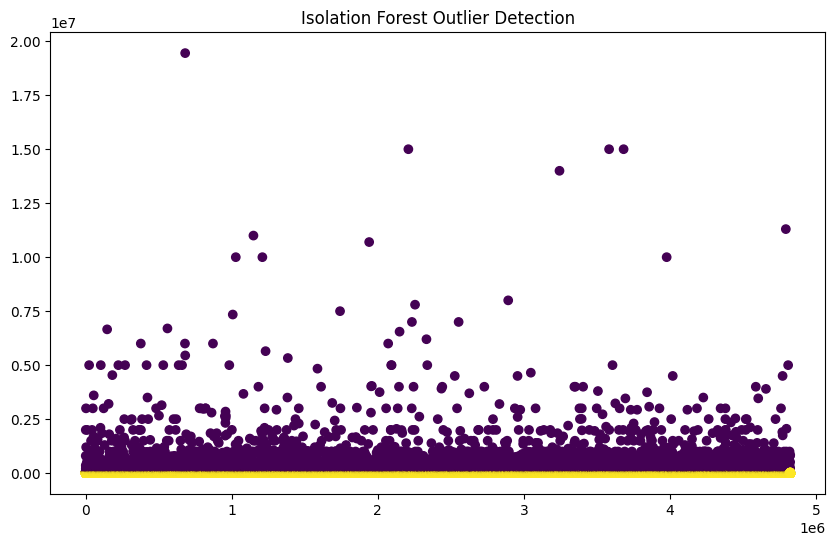

In [ ]:
# Visualização
plt.figure(figsize = (10, 6))
plt.scatter(tse_pandas.index, tse_pandas['valor_numerico'], c = tse_pandas['outlier_if'])
plt.title('Isolation Forest Outlier Detection')
plt.show()

**Conclusão**

Este estudo abordou a análise e detecção de outliers nas prestações de contas
eleitorais de 2024, utilizando um conjunto de dados massivos disponibilizado pelo Tribunal Superior Eleitoral (TSE). Através de técnicas de aprendizado de máquina, análise de grafos e métodos estatísticos, foi possível identificar padrões anômalos e investigar possíveis irregularidades nas transações financeiras realizadas pelos candidatos durante as campanhas eleitorais.

Os resultados da análise exploratória dos dados revelaram uma distribuição altamente assimétrica das transações financeiras, com presença significativa de valores extremos.

A aplicação de diferentes técnicas de detecção de outliers, como **Isolation Forest, Local Outlier Factor (LOF) e DBSCAN,** demonstrou que, embora todos os métodos fossem eficazes na identificação de outliers, cada um apresentou vantagens e limitações específicas. **Isolation Forest e LOF** mostraram alta sensibilidade, mas geraram muitos falsos positivos, enquanto **DBSCAN** apresentou uma melhor precisão na separação entre outliers e não-outliers.

A análise de grafos permitiu uma visualização clara das relações entre candidatos,contrapartes e partidos políticos, identificando os principais atores na rede de financiamento. A centralidade de grau revelou que certas entidades financeiras e partidos políticos desempenham um papel central nas transações financeiras, destacando a influência desproporcional de alguns nós na rede.

As análises temporais e por categoria de transação forneceram insights adicionais sobre as práticas financeiras nas campanhas eleitorais, evidenciando picos de transações antes e durante o período eleitoral, e uma predominância de transações realizadas por pessoas jurídicas e partidos políticos específicos.
Em termos de contribuição prática, este estudo não apenas proporcionou uma
compreensão detalhada das dinâmicas financeiras das campanhas eleitorais de 2024, mas também sugeriu melhorias para os processos de auditoria e fiscalização.

As técnicas de detecção de outliers e análise de grafos aplicadas podem ser utilizadas por órgãos reguladores e fiscalizadores para focar em áreas e transações que apresentam maior risco de irregularidades.

Além disso, a pesquisa contribui para a promoção da transparência e accountability no processo eleitoral, alinhando-se aos princípios da Política de Dados Abertos do TSE.

Ao utilizar um framework metodológico robusto que combina técnicas de
processamento de grandes volumes de dados, aprendizado de máquina e análise de
grafos, este estudo estabelece uma base sólida para futuras investigações e
aplicações em contextos similares.

Em resumo, a análise detalhada das transações financeiras eleitorais de 2024 revelou padrões significativos e outliers que merecem investigação adicional. As abordagens multidisciplinares utilizadas neste estudo fornecem uma compreensão profunda das interações financeiras e sugerem a necessidade de políticas mais rigorosas para assegurar a integridade e equidade no financiamento de campanhas eleitorais.

In [ ]:
# Encerra a sessão Spark
spark_session.stop()

# Fim